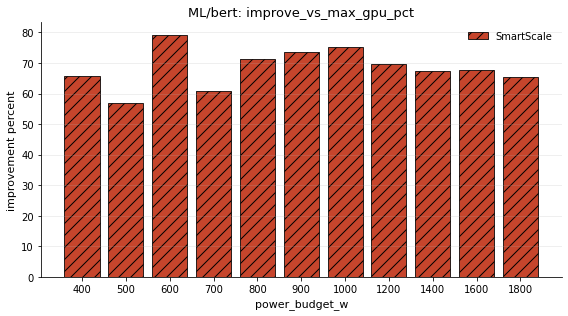

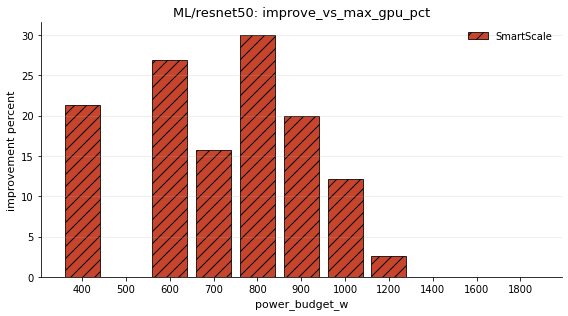

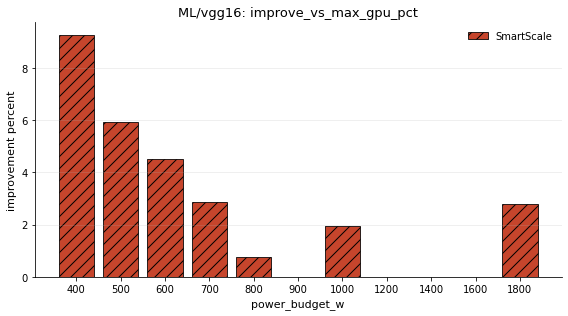

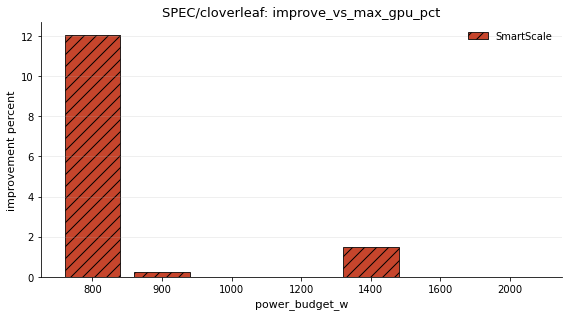

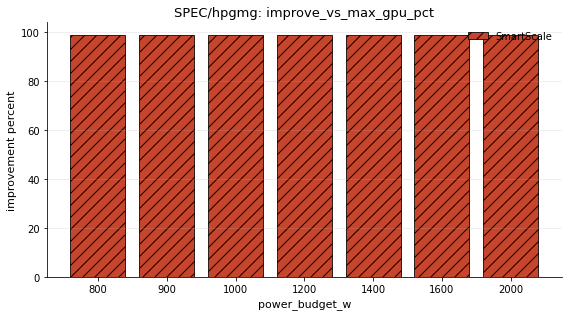

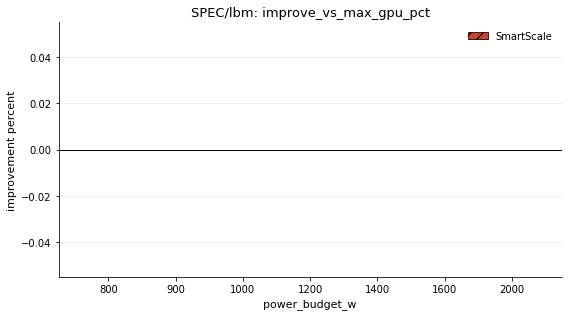

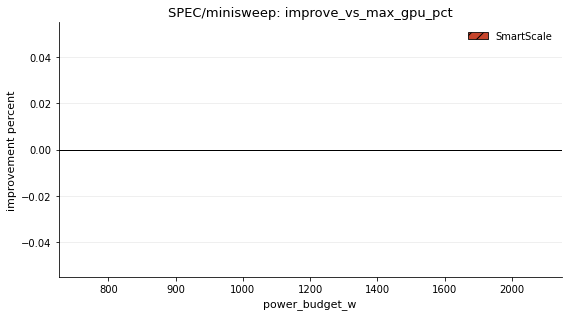

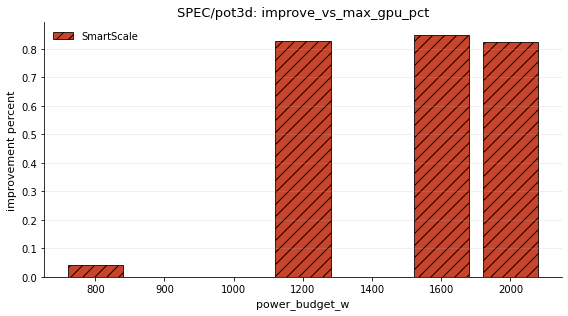

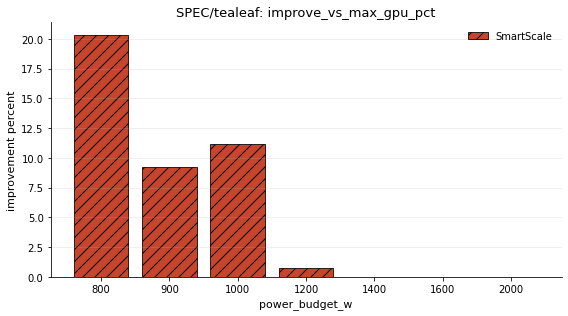

Generated figures in: /home/ac.zzheng/power/GPGPU/data/fig


In [11]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    # Notebook/IPython execution path.
    BASE_DIR = Path("/home/ac.zzheng/power/GPGPU/data")
DATA_ROOT = BASE_DIR / "H100"
OUT_DIR = BASE_DIR / "fig"

BOOTSTRAP_ITERS = 2000
BOOTSTRAP_SEED = 0

BASELINE_COLS = [
    "improve_vs_1gpu_pct",
    "improve_vs_2gpu_pct",
    "improve_vs_3gpu_pct",
    "improve_vs_4gpu_pct",
    "improve_vs_max_gpu_pct",
]

BASELINE_LABEL = {
    "improve_vs_1gpu_pct": "1gpu",
    "improve_vs_2gpu_pct": "2gpu",
    "improve_vs_3gpu_pct": "3gpu",
    "improve_vs_4gpu_pct": "4gpu",
    "improve_vs_max_gpu_pct": "max_gpu",
}


def configure_style():
    mpl.rcParams["font.family"] = "DejaVu Sans"
    mpl.rcParams["axes.titlesize"] = 13
    mpl.rcParams["axes.labelsize"] = 11
    mpl.rcParams["xtick.labelsize"] = 10
    mpl.rcParams["ytick.labelsize"] = 10
    mpl.rcParams["legend.fontsize"] = 10


def infer_suite(path: Path) -> str:
    p = str(path).lower()
    if "spec_power_motif" in p:
        return "SPEC"
    if "ml_power_motif" in p:
        return "ML"
    return "Unknown"


def infer_app(path: Path) -> str:
    name = path.name
    suffix = "_independent_per_cap_rankings.csv"
    return name[:-len(suffix)] if name.endswith(suffix) else path.stem


def load_rankings() -> pd.DataFrame:
    files = sorted(DATA_ROOT.glob("**/*_independent_per_cap_rankings.csv"))
    if not files:
        raise FileNotFoundError(f"No ranking CSV files found under {DATA_ROOT}")

    frames = []
    found_cols = set()
    for fp in files:
        try:
            df = pd.read_csv(fp)
        except Exception as exc:
            warnings.warn(f"Skip unreadable CSV {fp}: {exc}")
            continue

        if "power_cap" not in df.columns:
            warnings.warn(f"Skip CSV without power_cap: {fp}")
            continue

        df = df.copy()
        df["power_budget_w"] = pd.to_numeric(df["power_cap"], errors="coerce")
        df["suite"] = infer_suite(fp)
        df["app"] = infer_app(fp)
        if "suite" not in df.columns:
            df["suite"] = "Unknown"
        df["suite"] = df["suite"].fillna("Unknown")
        df["app_id"] = df["suite"].astype(str) + "/" + df["app"].astype(str)

        present = [c for c in BASELINE_COLS if c in df.columns]
        found_cols.update(present)
        for c in present:
            df[c] = pd.to_numeric(df[c], errors="coerce")

        keep = ["suite", "app", "app_id", "power_budget_w"] + present
        frames.append(df[keep])

    for c in BASELINE_COLS:
        if c not in found_cols:
            warnings.warn(f"Missing baseline column in dataset: {c} (will be skipped)")

    if not frames:
        raise ValueError("No valid ranking CSV content loaded.")

    out = pd.concat(frames, ignore_index=True)
    out = out.dropna(subset=["power_budget_w"]).copy()
    out["power_budget_w"] = out["power_budget_w"].astype(int)
    return out


def bootstrap_mean_ci(values: np.ndarray, n_boot=2000, seed=0):
    values = values[np.isfinite(values)]
    if values.size == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.RandomState(seed)
    n = values.size
    idx = rng.randint(0, n, size=(n_boot, n))
    samples = values[idx]
    means = samples.mean(axis=1)
    return float(values.mean()), float(np.percentile(means, 2.5)), float(np.percentile(means, 97.5))


def strip_spines_and_grid(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", alpha=0.25)


def figure1_avg_trend(df: pd.DataFrame):
    present_cols = [c for c in BASELINE_COLS if c in df.columns]
    if not present_cols:
        warnings.warn("Figure1 skipped: no baseline columns present")
        return

    budgets = sorted(df["power_budget_w"].dropna().unique().tolist())
    fig, ax = plt.subplots(figsize=(9, 5))

    emphasis = "improve_vs_max_gpu_pct"
    color_map = {
        "improve_vs_max_gpu_pct": "#C6452C",
        "improve_vs_1gpu_pct": "#5DA9B8",
        "improve_vs_2gpu_pct": "#7DAA9F",
        "improve_vs_3gpu_pct": "#9BBFA6",
        "improve_vs_4gpu_pct": "#B8C9B0",
    }

    for col in present_cols:
        means, lows, highs = [], [], []
        for b in budgets:
            vals = df.loc[df["power_budget_w"] == b, col].to_numpy(dtype=float)
            m, lo, hi = bootstrap_mean_ci(vals, n_boot=BOOTSTRAP_ITERS, seed=BOOTSTRAP_SEED)
            means.append(m)
            lows.append(lo)
            highs.append(hi)

        is_focus = (col == emphasis)
        alpha = 0.95 if is_focus else 0.5
        lw = 2.5 if is_focus else 1.8
        z = 5 if is_focus else 3
        ax.plot(budgets, means, label=BASELINE_LABEL[col], color=color_map.get(col, None), linewidth=lw, alpha=alpha, zorder=z)
        ax.fill_between(budgets, lows, highs, color=color_map.get(col, None), alpha=0.18 if is_focus else 0.08, zorder=z - 1)

    ax.set_xlabel("power_budget_w")
    ax.set_ylabel("mean improvement percent")
    ax.set_title("Figure1: Average Improvement Trend with 95% Bootstrap CI")
    strip_spines_and_grid(ax)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    fig.tight_layout()

    fig.savefig(OUT_DIR / "Figure1_avg_trend.pdf")
    fig.savefig(OUT_DIR / "Figure1_avg_trend.png", dpi=300)
    plt.show()
    plt.close(fig)


def figure2_distribution(df: pd.DataFrame):
    present_cols = [c for c in BASELINE_COLS if c in df.columns]
    if not present_cols:
        warnings.warn("Figure2 skipped: no baseline columns present")
        return

    order_cols = [c for c in [
        "improve_vs_1gpu_pct",
        "improve_vs_2gpu_pct",
        "improve_vs_3gpu_pct",
        "improve_vs_4gpu_pct",
        "improve_vs_max_gpu_pct",
    ] if c in present_cols]

    long_df = df.melt(
        id_vars=["suite", "app_id", "power_budget_w"],
        value_vars=order_cols,
        var_name="baseline_col",
        value_name="improvement_percent",
    )
    long_df = long_df.dropna(subset=["improvement_percent"]).copy()
    long_df["baseline"] = long_df["baseline_col"].map(BASELINE_LABEL)

    suites = ["SPEC", "ML"]
    fig, axes = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

    global_min = float(long_df["improvement_percent"].min()) if not long_df.empty else -1.0
    global_max = float(long_df["improvement_percent"].max()) if not long_df.empty else 1.0
    pad = max(1.0, 0.08 * (global_max - global_min))
    y_min, y_max = global_min - pad, global_max + pad

    baseline_order = [BASELINE_LABEL[c] for c in order_cols]

    for ax, suite in zip(axes, suites):
        sub = long_df[long_df["suite"].fillna("Unknown") == suite]
        if sub.empty:
            ax.text(0.5, 0.5, f"No data for {suite}", ha="center", va="center", transform=ax.transAxes)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f"{suite}")
            strip_spines_and_grid(ax)
            continue

        sns.boxplot(
            data=sub,
            x="baseline",
            y="improvement_percent",
            order=baseline_order,
            ax=ax,
            color="#9ecae1",
            width=0.6,
            fliersize=2,
        )

        for i, base in enumerate(baseline_order):
            vals = sub.loc[sub["baseline"] == base, "improvement_percent"].dropna().to_numpy()
            if vals.size == 0:
                continue
            med = float(np.median(vals))
            frac_pos = float((vals > 0).mean() * 100.0)
            ax.text(
                i,
                med + 0.02 * (y_max - y_min),
                f"med={med:.1f}\n>0={frac_pos:.0f}%",
                ha="center",
                va="bottom",
                fontsize=9,
            )

        ax.set_ylim(y_min, y_max)
        ax.set_title(suite)
        ax.set_xlabel("")
        ax.set_ylabel("improvement percent")
        strip_spines_and_grid(ax)

    axes[-1].set_xlabel("baseline type")
    fig.suptitle("Figure2: Distribution of Improvement by Baseline")
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    fig.savefig(OUT_DIR / "Figure2_distribution.pdf")
    fig.savefig(OUT_DIR / "Figure2_distribution.png", dpi=300)
    plt.show()
    plt.close(fig)


def figure3_heatmap_app_cap(df: pd.DataFrame):
    col = "improve_vs_max_gpu_pct"
    if col not in df.columns:
        warnings.warn("Figure3 skipped: improve_vs_max_gpu_pct missing")
        return

    hdf = df[["suite", "app", "app_id", "power_budget_w", col]].copy()
    hdf = hdf.dropna(subset=[col, "power_budget_w"])
    if hdf.empty:
        warnings.warn("Figure3 skipped: no valid data")
        return

    app_order = (
        hdf.groupby("app_id")[col]
        .mean()
        .sort_values(ascending=False)
        .index.tolist()
    )
    budget_order = sorted(hdf["power_budget_w"].astype(int).unique().tolist())

    piv = hdf.pivot_table(index="app_id", columns="power_budget_w", values=col, aggfunc="mean")
    piv = piv.reindex(index=app_order, columns=budget_order)

    vmax = np.nanmax(np.abs(piv.to_numpy(dtype=float)))
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0

    fig, ax = plt.subplots(figsize=(10, max(4, 0.35 * len(app_order))))
    sns.heatmap(
        piv,
        ax=ax,
        cmap="RdBu_r",
        center=0,
        vmin=-vmax,
        vmax=vmax,
        cbar_kws={"label": "improvement percent"},
        linewidths=0.3,
        linecolor="white",
    )

    # annotate only |value| >= 5
    for yi, app in enumerate(piv.index):
        for xi, budget in enumerate(piv.columns):
            v = piv.loc[app, budget]
            if pd.notna(v) and abs(v) >= 5.0:
                ax.text(xi + 0.5, yi + 0.5, f"{v:.1f}", ha="center", va="center", fontsize=8, color="black")

    ax.set_xlabel("power_budget_w")
    ax.set_ylabel("apps")
    ax.set_title("Figure3: Heatmap of improve_vs_max_gpu_pct")
    fig.tight_layout()

    fig.savefig(OUT_DIR / "Figure3_heatmap_app_cap.pdf")
    fig.savefig(OUT_DIR / "Figure3_heatmap_app_cap.png", dpi=300)
    plt.show()
    plt.close(fig)


def figure4_extremes_bar(df: pd.DataFrame):
    col = "improve_vs_max_gpu_pct"
    if col not in df.columns:
        warnings.warn("Figure4 skipped: improve_vs_max_gpu_pct missing")
        return

    g = (
        df.groupby(["suite", "app", "app_id"], dropna=False)[col]
        .mean()
        .reset_index()
        .sort_values(col, ascending=False)
    )

    if g.empty:
        warnings.warn("Figure4 skipped: no valid data")
        return

    fig, ax = plt.subplots(figsize=(10, max(4, 0.35 * len(g))))
    colors = np.where(g[col] >= 0, "#2E8B57", "#C6452C")
    y = np.arange(len(g))
    ax.barh(y, g[col].to_numpy(), color=colors, edgecolor="black", linewidth=0.6)
    ax.invert_yaxis()

    ax.axvline(0, color="black", linewidth=1.0)
    ax.set_yticks(y)
    ax.set_yticklabels(g["app_id"].tolist())
    ax.set_xlabel("improvement percent")
    ax.set_title("Figure4: Per-App Average improve_vs_max_gpu_pct")
    strip_spines_and_grid(ax)

    # top 3 and bottom 1 annotations
    top_n = min(3, len(g))
    top_idx = list(range(top_n))
    bottom_idx = [len(g) - 1] if len(g) > 0 else []
    anno_idx = sorted(set(top_idx + bottom_idx))
    for idx in anno_idx:
        val = float(g.iloc[idx][col])
        ax.text(val + (0.8 if val >= 0 else -0.8), idx, f"{val:.2f}%", va="center", ha="left" if val >= 0 else "right", fontsize=9)

    fig.tight_layout()

    fig.savefig(OUT_DIR / "Figure4_extremes_bar.pdf")
    fig.savefig(OUT_DIR / "Figure4_extremes_bar.png", dpi=300)
    plt.show()
    plt.close(fig)


def figure_per_app_vs_max_gpu(df: pd.DataFrame):
    col = "improve_vs_max_gpu_pct"
    if col not in df.columns:
        warnings.warn("Per-app plot skipped: improve_vs_max_gpu_pct missing")
        return

    sub = df[["suite", "app", "app_id", "power_budget_w", col]].copy()
    sub = sub.dropna(subset=["power_budget_w", col])
    if sub.empty:
        warnings.warn("Per-app plot skipped: no valid data")
        return

    for app_id, g in sub.groupby("app_id"):
        g = g.sort_values("power_budget_w")
        fig, ax = plt.subplots(figsize=(8, 4.5))
        x = np.arange(len(g))
        bars = ax.bar(
            x,
            g[col].to_numpy(),
            color="#C6452C",
            edgecolor="black",
            linewidth=0.8,
            label="SmartScale",
        )
        for b in bars:
            b.set_hatch("//")
        ax.axhline(0, color="black", linewidth=1.0)
        ax.set_xticks(x)
        ax.set_xticklabels([str(int(v)) for v in g["power_budget_w"].to_numpy()])
        ax.set_xlabel("power_budget_w")
        ax.set_ylabel("improvement percent")
        ax.set_title(f"{app_id}: improve_vs_max_gpu_pct")
        strip_spines_and_grid(ax)
        ax.legend(frameon=False)
        fig.tight_layout()

        safe_name = app_id.replace("/", "_")
        fig.savefig(OUT_DIR / f"{safe_name}_vs_max_gpu.pdf")
        fig.savefig(OUT_DIR / f"{safe_name}_vs_max_gpu.png", dpi=300)
        plt.show()
        plt.close(fig)


def main():
    configure_style()
    df = load_rankings()

    # Ensure suite exists; missing treated as Unknown.
    if "suite" not in df.columns:
        df["suite"] = "Unknown"
    df["suite"] = df["suite"].fillna("Unknown")

    figure_per_app_vs_max_gpu(df)

    print("Generated figures in:", OUT_DIR)


if __name__ == "__main__":
    main()
